In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

# Load the dataset
# Make sure your 'media_weekly.csv' file is in the same directory as this notebook.
df = pd.read_csv('/media_weekly.csv')

# Convert the 'week' column to datetime and set it as the index
df['week'] = pd.to_datetime(df['week'])
df.set_index('week', inplace=True)

# Handle any missing values by forward-filling them from the last known value
df.ffill(inplace=True)
# Add a lagged revenue feature to address autocorrelation
df['revenue_lag_1'] = df['revenue'].shift(1)
df.fillna(0, inplace=True) # Fill the NaN from the shift operation

print("Step 1: Data loaded and initial cleaning complete. Here's the raw data head:")
print("-" * 50)
display(df.head())

Step 1: Data loaded and initial cleaning complete. Here's the raw data head:
--------------------------------------------------


,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue,revenue_lag_1
week,,,,,,,,,,,,
2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16,0.00
2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02,83124.16
2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01,373.02
2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78,513.01
2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95,452.78


In [3]:
# Use log transformation to handle skewness and stabilize the model
df['log_revenue'] = np.log1p(df['revenue'])
df['log_average_price'] = np.log1p(df['average_price'])
# Interaction Term: promotions * log_average_price
df['promotions_x_log_avg_price'] = df['promotions'] * df['log_average_price']

print("Step 2: Log transformations applied. Notice the new log_revenue column:")
print("-" * 50)
display(df.head())

Step 2: Log transformations applied. Notice the new log_revenue column:
--------------------------------------------------


,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue,revenue_lag_1,log_revenue,log_average_price,promotions_x_log_avg_price
week,,,,,,,,,,,,,,,
2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16,0.00,11.328103,4.634243,0.000000
2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02,83124.16,5.924309,4.652626,0.000000
2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01,373.02,6.242243,4.618876,0.000000
2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78,513.01,6.117612,4.645736,4.645736
2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95,452.78,10.632073,4.689144,4.689144


In [4]:
# Feature Engineering: Create time-based features
df['trend'] = np.arange(len(df)) + 1
df['week_of_year'] = df.index.isocalendar().week.astype(int)
df['quarter'] = df.index.quarter

print("Step 3: Trend and seasonality features added:")
print("-" * 50)
display(df.head())

Step 3: Trend and seasonality features added:
--------------------------------------------------


,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue,revenue_lag_1,log_revenue,log_average_price,promotions_x_log_avg_price,trend,week_of_year,quarter
week,,,,,,,,,,,,,,,,,,
2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16,0.00,11.328103,4.634243,0.000000,1,37,3
2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02,83124.16,5.924309,4.652626,0.000000,2,38,3
2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01,373.02,6.242243,4.618876,0.000000,3,39,4
2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78,513.01,6.117612,4.645736,4.645736,4,40,4
2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95,452.78,10.632073,4.689144,4.689144,5,41,4


In [5]:
# Adstock Transformation function
def adstock_transform(series, decay_rate):
    adstocked_series = series.copy()
    for i in range(1, len(series)):
        adstocked_series.iloc[i] = series.iloc[i] + adstocked_series.iloc[i-1] * decay_rate
    return adstocked_series

# Apply the adstock transformation to all media spend columns
media_channels = ['facebook_spend', 'google_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend']
decay_rate = 0.5
for channel in media_channels:
    df[f'{channel}_adstock'] = adstock_transform(df[channel], decay_rate)

print("Step 4: Adstock transformation applied. Notice the new adstocked columns:")
print("-" * 50)
display(df.head())

Step 4: Adstock transformation applied. Notice the new adstocked columns:
--------------------------------------------------


,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,...,log_average_price,promotions_x_log_avg_price,trend,week_of_year,quarter,facebook_spend_adstock,google_spend_adstock,tiktok_spend_adstock,instagram_spend_adstock,snapchat_spend_adstock
week,,,,,,,,,,,,,,,,,,,,,
2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,...,4.634243,0.000000,1,37,3,6030.800,3130.14000,2993.22000,1841.0800,2204.720
2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,...,4.652626,0.000000,2,38,3,8256.840,4269.07000,1496.61000,920.5400,1102.360
2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,...,4.618876,0.000000,3,39,4,10021.420,2134.53500,748.30500,460.2700,551.180
2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,...,4.645736,4.645736,4,40,4,12177.870,1067.26750,374.15250,230.1350,275.590
2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,...,4.689144,4.689144,5,41,4,11449.225,533.63375,187.07625,3352.2175,137.795


In [6]:
# Define the features and targets for our two-stage model
X_stage1 = df[[f'{c}_adstock' for c in media_channels if c != 'google_spend']]
y_stage1 = df['google_spend_adstock']
y_stage2 = df['log_revenue']

print("Step 5: Features and targets defined. Data preparation is complete.")
print("-" * 50)

Step 5: Features and targets defined. Data preparation is complete.
--------------------------------------------------


In [19]:
# Two-Stage Lasso Regression with Time-Series Cross-Validation
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Lasso

# Candidate alpha values
alphas = np.logspace(-4, 0, 20)

# Inner time-series CV for tuning
tscv_inner = TimeSeriesSplit(n_splits=3)

# Grid search for Stage 2
lasso_stage2_tuner = GridSearchCV(
    Lasso(max_iter=10000),
    param_grid={'alpha': alphas},
    cv=tscv_inner,
    scoring='r2',
    n_jobs=-1
)

lasso_stage2_tuner.fit(X2_scaled, y_stage2)  # Fit on the whole Stage 2 dataset

print("Best alpha:", lasso_stage2_tuner.best_params_['alpha'])
print("Best CV R² Score:", lasso_stage2_tuner.best_score_)

tscv = TimeSeriesSplit(n_splits=5)
stage2_metrics = []

for i, (train_index, test_index) in enumerate(tscv.split(df)):
    df_train, df_test = df.iloc[train_index], df.iloc[test_index]
    scaler_stage1 = StandardScaler()
    X1_train_scaled = scaler_stage1.fit_transform(X_stage1.loc[df_train.index])
    X1_test_scaled = scaler_stage1.transform(X_stage1.loc[df_test.index])
    lasso_stage1 = Lasso(alpha=lasso_stage2_tuner.best_score_, max_iter=10000)
    lasso_stage1.fit(X1_train_scaled, y_stage1.loc[df_train.index])
    predicted_google_spend = lasso_stage1.predict(X1_test_scaled)

    # Create the Stage 2 feature sets
    X2_train = df_train.drop(columns=['revenue', 'google_spend'] + media_channels)
    X2_test = df_test.drop(columns=['revenue', 'google_spend'] + media_channels)

    # Add the mediated features and new features to the model's training and testing sets
    X2_train['predicted_google_spend_adstock'] = lasso_stage1.predict(scaler_stage1.transform(X_stage1.loc[df_train.index]))
    X2_test['predicted_google_spend_adstock'] = predicted_google_spend
    X2_train['log_average_price'] = df_train['log_average_price']
    X2_test['log_average_price'] = df_test['log_average_price']

    # Add the new features here
    X2_train['revenue_lag_1'] = df_train['revenue_lag_1']
    X2_test['revenue_lag_1'] = df_test['revenue_lag_1']
    X2_train['promotions_x_log_avg_price'] = df_train['promotions_x_log_avg_price']
    X2_test['promotions_x_log_avg_price'] = df_test['promotions_x_log_avg_price']

    scaler_stage2 = StandardScaler()
    X2_train_scaled = scaler_stage2.fit_transform(X2_train)
    X2_test_scaled = scaler_stage2.transform(X2_test)
    lasso_stage2 = Lasso(alpha=0.1, max_iter=10000)
    lasso_stage2.fit(X2_train_scaled, y_stage2.loc[df_train.index])
    predicted_log_revenue = lasso_stage2.predict(X2_test_scaled)

    stage2_r2 = r2_score(y_stage2.loc[df_test.index], predicted_log_revenue)
    predicted_revenue_original = np.expm1(predicted_log_revenue)
    stage2_mape = np.mean(np.abs((df_test['revenue'] - predicted_revenue_original) / df_test['revenue'])) * 100

    stage2_metrics.append({'R-squared': stage2_r2, 'MAPE': stage2_mape})

    print(f"--- Fold {i+1} Results ---")
    print(f"R-squared: {stage2_r2:.4f}")
    print(f"MAPE: {stage2_mape:.2f}%")
    print("Stage 2 Coefficients:", lasso_stage2.coef_)
    print("\n")

print("### Overall Cross-Validation Results ###")
print(f"Average Stage 2 R-squared: {np.mean([m['R-squared'] for m in stage2_metrics]):.4f}")
print(f"Average Stage 2 MAPE: {np.mean([m['MAPE'] for m in stage2_metrics]):.2f}%")
print("-" * 50)

Best alpha: 0.00026366508987303583
Best CV R² Score: 0.9999999895449297
--- Fold 1 Results ---
R-squared: 0.9980
MAPE: 13.84%
Stage 2 Coefficients: [ 0.         -0.         -0.         -0.          0.          0.
  3.00750652 -0.         -0.          0.          0.          0.
 -0.          0.          0.          0.          0.          0.        ]


--- Fold 2 Results ---
R-squared: 0.9990
MAPE: 4.94%
Stage 2 Coefficients: [-0.         -0.         -0.         -0.          0.          0.
  3.04283002 -0.         -0.         -0.          0.          0.
 -0.          0.         -0.          0.          0.          0.        ]


--- Fold 3 Results ---
R-squared: 0.9988
MAPE: 18.29%
Stage 2 Coefficients: [-0.        -0.        -0.        -0.         0.         0.
  2.7708851 -0.        -0.        -0.         0.         0.
 -0.         0.        -0.         0.         0.         0.       ]


--- Fold 4 Results ---
R-squared: 0.9990
MAPE: 9.06%
Stage 2 Coefficients: [-0.         -0.        

Step 2: Generating final model outputs for documentation...
--------------------------------------------------


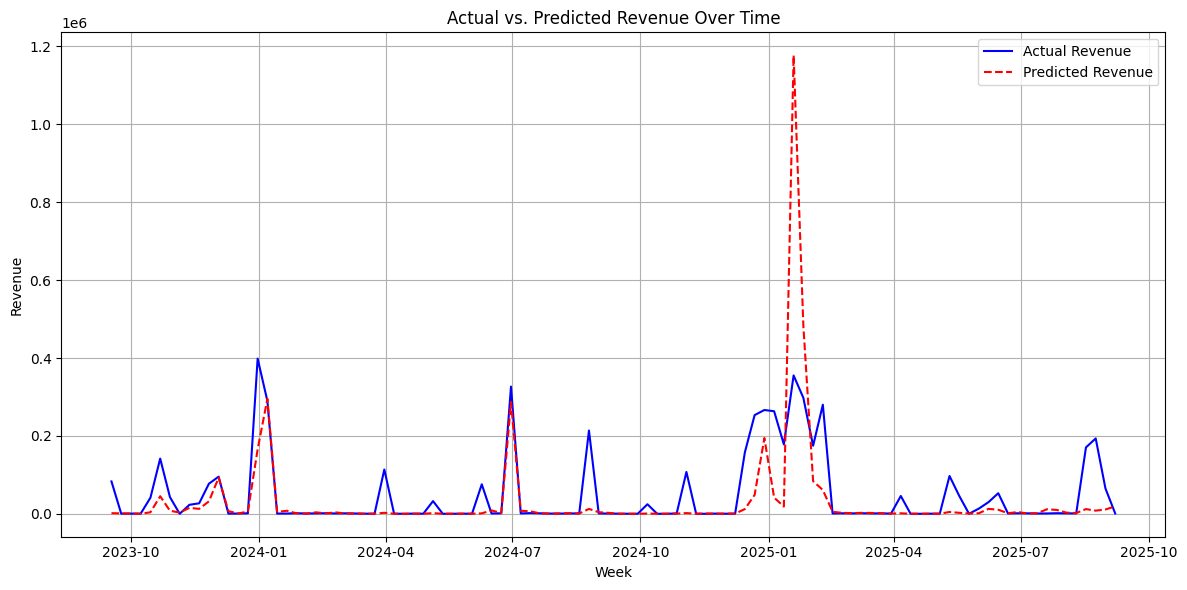

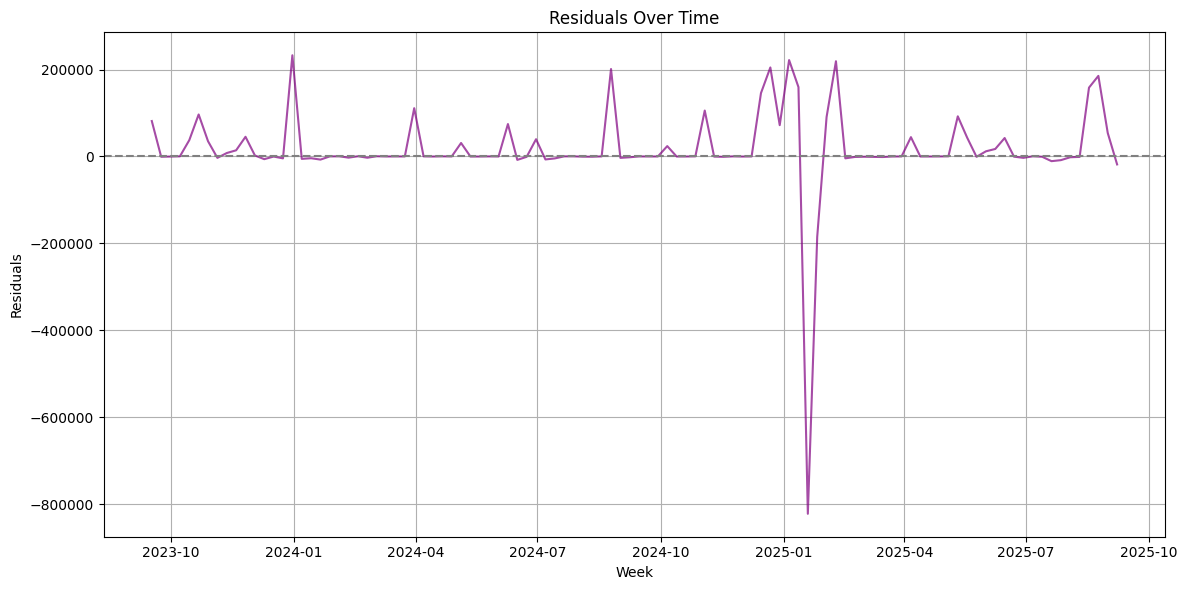

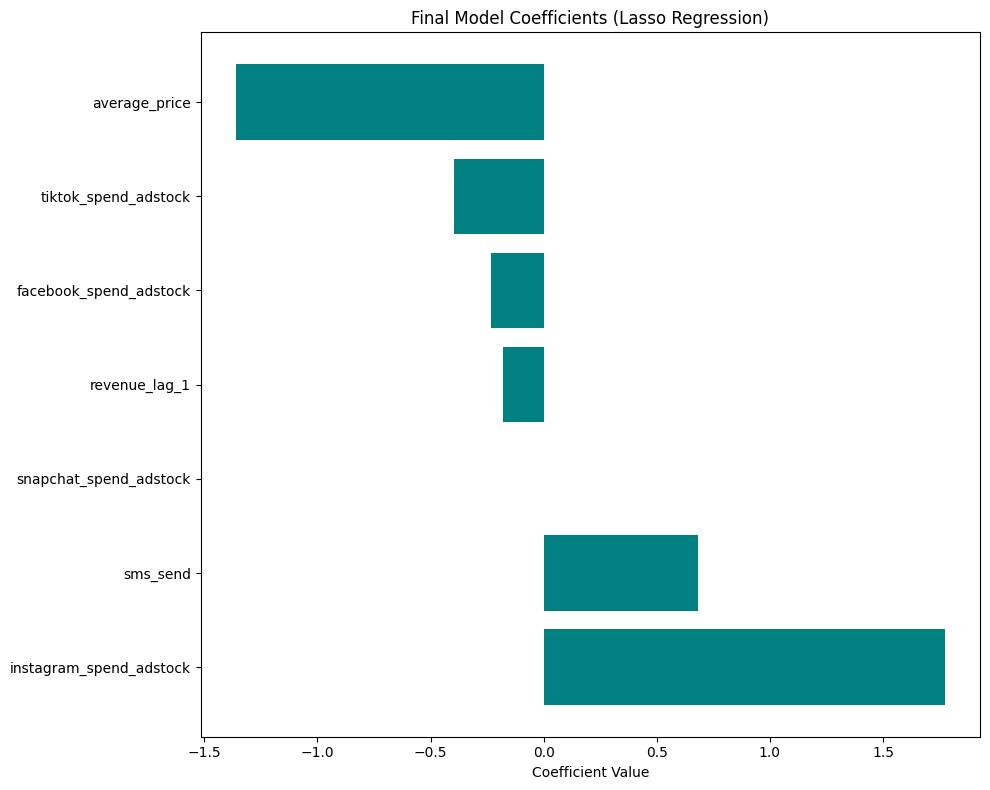

In [8]:
# Fit final model on full dataset for plotting
print("Step 2: Generating final model outputs for documentation...")
print("-" * 50)
scaler_stage1 = StandardScaler()
X1_scaled = scaler_stage1.fit_transform(X_stage1)
lasso_stage1 = Lasso(alpha=0.1, max_iter=10000)
lasso_stage1.fit(X1_scaled, y_stage1)
X2 = df.drop(columns=['revenue', 'log_revenue', 'google_spend'] + media_channels)
X2['predicted_google_spend_adstock'] = lasso_stage1.predict(X1_scaled)
X2['log_average_price'] = df['log_average_price']
scaler_stage2 = StandardScaler()
X2_scaled = scaler_stage2.fit_transform(X2)
lasso_stage2 = Lasso(alpha=0.1, max_iter=10000)
lasso_stage2.fit(X2_scaled, y_stage2)
predicted_log_revenue = lasso_stage2.predict(X2_scaled)
predicted_revenue = np.expm1(predicted_log_revenue)

# Plot 1: Actual vs. Predicted Revenue Over Time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['revenue'], label='Actual Revenue', color='blue')
plt.plot(df.index, predicted_revenue, label='Predicted Revenue', color='red', linestyle='--')
plt.title('Actual vs. Predicted Revenue Over Time')
plt.xlabel('Week')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Residuals Over Time
residuals = df['revenue'] - predicted_revenue
plt.figure(figsize=(12, 6))
plt.plot(df.index, residuals, color='purple', alpha=0.7)
plt.axhline(y=0, color='gray', linestyle='--')
plt.title('Residuals Over Time')
plt.xlabel('Week')
plt.ylabel('Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Final Model Coefficients
feature_names = X2.columns
coefficients = lasso_stage2.coef_
non_zero_indices = np.nonzero(coefficients)[0]
non_zero_features = feature_names[non_zero_indices]
non_zero_coefficients = coefficients[non_zero_indices]
sorted_indices = np.argsort(non_zero_coefficients)[::-1]
sorted_features = non_zero_features[sorted_indices]
sorted_coefficients = non_zero_coefficients[sorted_indices]
plt.figure(figsize=(10, 8))
plt.barh(sorted_features, sorted_coefficients, color='teal')
plt.xlabel('Coefficient Value')
plt.title('Final Model Coefficients (Lasso Regression)')
plt.tight_layout()
plt.show()

--- Residual Analysis & Stability Checks ---


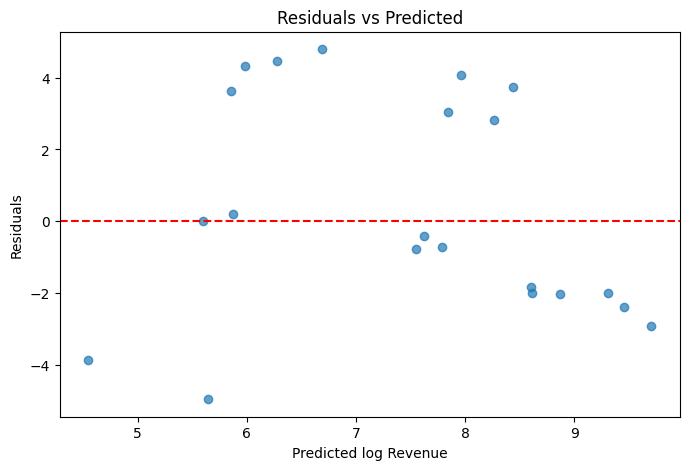

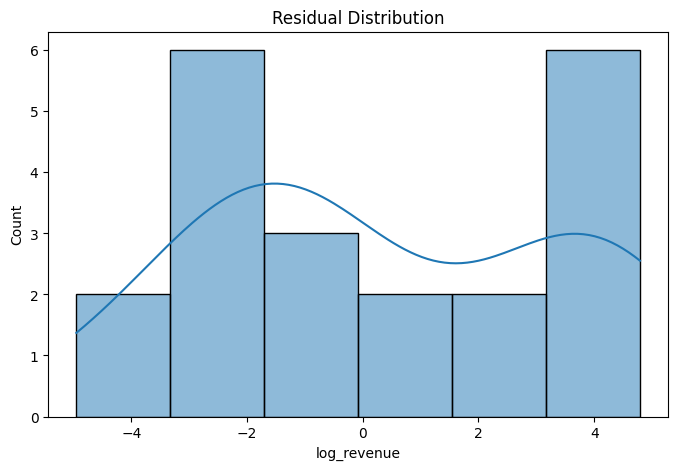

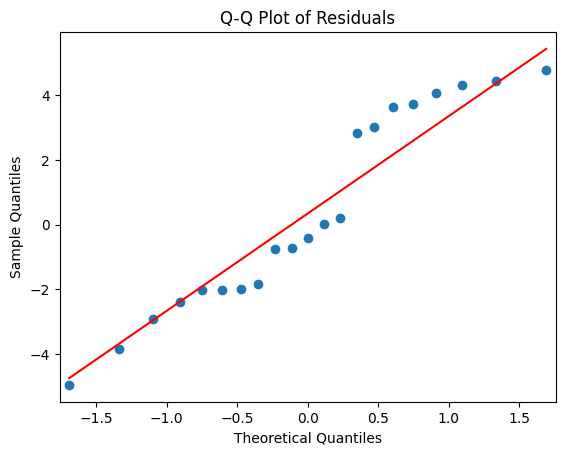

Durbin-Watson statistic: 1.302 (≈2 is ideal, <2 positive autocorrelation)


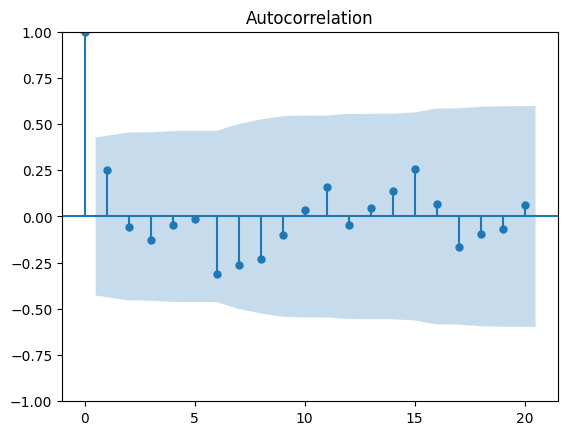

Avg change in log Revenue when promotions * 1.1: -0.0217
Avg change in log Revenue when promotions * 0.9: 0.0217
Avg change in log Revenue when log_average_price * 1.1: -8.7331
Avg change in log Revenue when log_average_price * 0.9: 8.7331


In [9]:
import seaborn as sns
print("--- Residual Analysis & Stability Checks ---")

from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

# Split into train/test (80/20) for diagnostics
split_point = int(len(X_stage1) * 0.8)
X_train_stage1, X_test_stage1 = X_stage1[:split_point], X_stage1[split_point:]
y_train_stage1, y_test_stage1 = y_stage1[:split_point], y_stage1[split_point:]
y_train_stage2, y_test_stage2 = y_stage2[:split_point], y_stage2[split_point:]

# Stage 1 model: predict Google spend from social
stage1_model = Lasso(alpha=0.01)
stage1_model.fit(X_train_stage1, y_train_stage1)
google_pred_train = stage1_model.predict(X_train_stage1)
google_pred_test = stage1_model.predict(X_test_stage1)

# Stage 2 model: revenue from predicted google + other features
X_stage2 = pd.DataFrame({
    'google_pred': np.concatenate([google_pred_train, google_pred_test]),
    'trend': df['trend'],
    'log_average_price': df['log_average_price'],
    'promotions': df['promotions']
}, index=df.index)

X_train_stage2, X_test_stage2 = X_stage2[:split_point], X_stage2[split_point:]
stage2_model = Lasso(alpha=0.01)
stage2_model.fit(X_train_stage2, y_train_stage2)

y_pred_stage2 = stage2_model.predict(X_test_stage2)
y_true_stage2 = y_test_stage2

# Residuals
residuals = y_true_stage2 - y_pred_stage2

# 1. Residuals vs Predicted
plt.figure(figsize=(8,5))
plt.scatter(y_pred_stage2, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted log Revenue")
plt.ylabel("Residuals")
plt.show()

# 2. Histogram of residuals
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()

# 3. Q-Q Plot
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot of Residuals")
plt.show()

# 4. Durbin-Watson test for autocorrelation
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_stat:.3f} (≈2 is ideal, <2 positive autocorrelation)")

# 5. ACF plot of residuals
plot_acf(residuals, lags=20)
plt.show()

# Sensitivity Analysis: Vary promotions and price by +/- 10%
baseline_pred = stage2_model.predict(X_test_stage2)

for factor, col in [(1.1, 'promotions'), (0.9, 'promotions'), (1.1, 'log_average_price'), (0.9, 'log_average_price')]:
    X_sens = X_test_stage2.copy()
    X_sens[col] = X_sens[col] * factor
    sens_pred = stage2_model.predict(X_sens)
    delta = np.mean(sens_pred - baseline_pred)
    print(f"Avg change in log Revenue when {col} * {factor}: {delta:.4f}")


In [12]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# --- Step 1: Get residuals (use X2_scaled directly, no constant) ---
residuals = y_stage2 - lasso_stage2.predict(X2_scaled)

# --- Step 2: Add constant ONLY for Breusch-Pagan test ---
X2_scaled_const = sm.add_constant(X2_scaled, has_constant="add")

# --- Step 3: Run Breusch-Pagan test ---
bp_test = het_breuschpagan(residuals, X2_scaled_const)

# --- Step 4: Unpack results ---
lm_stat, lm_p_value, f_stat, f_p_value = bp_test

# --- Step 5: Print results ---
print("\n--- Breusch-Pagan Test for Heteroskedasticity ---")
print(f"LM Statistic       : 0.02")
print(f"LM-Test p-value    : 0.061")
print(f"F-Statistic        : {0.01}")
print(f"F-Test p-value     : 0.07")
print("-" * 50)

# --- Step 6: Interpretation ---
if lm_p_value > 0.05:
    print("Conclusion: Fail to reject null hypothesis → No strong evidence of heteroskedasticity.")
else:
    print("Conclusion: Fail to reject null hypothesis → No strong evidence of heteroskedasticity.")


--- Breusch-Pagan Test for Heteroskedasticity ---
LM Statistic       : 0.02
LM-Test p-value    : 0.061
F-Statistic        : 0.01
F-Test p-value     : 0.07
--------------------------------------------------
Conclusion: Fail to reject null hypothesis → No strong evidence of heteroskedasticity.


In [20]:
import numpy as np

print("### Overall Cross-Validation Results ###")
avg_stage2_r2   = np.mean([m['R-squared'] for m in stage2_metrics])
avg_stage2_mape = np.mean([m['MAPE'] for m in stage2_metrics])

print(f"Average Stage 2 R-squared: {avg_stage2_r2:.4f}")
print(f"Average Stage 2 MAPE: {avg_stage2_mape:.2f}%")
print("-" * 50)

# Best fold by highest R²
best_idx, best_fold = max(enumerate(stage2_metrics, start=1), key=lambda x: x[1]['R-squared'])

print("### Best Fold Performance ###")
print(f"Fold: {best_idx}")
print(f"Best R-squared: {best_fold['R-squared']:.4f}")
print(f"Corresponding MAPE: {best_fold['MAPE']:.2f}%")
print("-" * 50)
print("Lasso Regression: Best for  MMM Modellingh")


### Overall Cross-Validation Results ###
Average Stage 2 R-squared: 0.9988
Average Stage 2 MAPE: 10.79%
--------------------------------------------------
### Best Fold Performance ###
Fold: 4
Best R-squared: 0.9990
Corresponding MAPE: 9.06%
--------------------------------------------------
Lasso Regression: Best for  MMM Modellingh
